In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import sklearn.metrics as skm
from helper_functions import NUM2STR, STR2NUM
from helper_functions import mean_std, median_iqr, perc_transition

In [51]:
wdir = "output/cv"
wdir_demo = "output/demographics/"
feat_fp = "output/features/features_nsrr_shhs2.parquet"
ecg_feat_fp = "output/features/features_ecg_nsrr_shhs2.parquet"
out_dir = "output/plots/"

In [44]:
# Choose model (set in config) -------------------
# model = "eeg+eog+emg+demo"
model = "eeg+eog+emg+ecg+demo"

df = pd.read_parquet(wdir + "/cv_loo_nsrr_shhs.parquet")
# df['subj'] = df['subj'].astype(str)
df_demo = pd.read_csv(wdir_demo + "shhs_demo.csv").set_index('subj')

In [45]:
df_demo

,age,male,bmi,ahi,ethnicity,set,hypertension
subj,,,,,,,
200077,41.0,1,23.388687,9.738220,caucasian,excluded,0.0
200078,54.0,1,30.211833,19.685039,caucasian,excluded,1.0
200079,56.0,0,35.451050,26.000000,other,excluded,0.0
200080,54.0,1,32.645673,12.450000,caucasian,excluded,0.0
200081,40.0,0,31.644286,2.632794,caucasian,excluded,0.0
...,...,...,...,...,...,...,...
205798,59.0,1,30.804282,13.350000,caucasian,training,1.0
205799,54.0,0,33.059629,NaN,caucasian,excluded,0.0
205800,66.0,1,26.418929,56.115108,caucasian,excluded,1.0


In [46]:
# Per each night
df_scores = []

labels = ['N1', 'N2', 'N3', 'R', 'W']

for sub in tqdm(df['subj'].unique(), leave=False):
    df_sub = df[df['subj'] == sub]
    yt = df_sub['y_true']
    yp = df_sub['y_pred']
    n = yt.shape[0]

    sub_scores = {
        # Accuracy
        'accuracy': 100 * skm.accuracy_score(yt, yp),
        'kappa': 100 * skm.cohen_kappa_score(yt, yp, labels=labels),
        'mcc': 100 * skm.matthews_corrcoef(yt, yp),
        'f1_macro': 100 * skm.f1_score(yt, yp, labels=labels, average='macro', zero_division=1),
        # % Transitions
        'dur_hours': (yt.size / 2) / 60,
        'perc_trans_true': perc_transition(yt),
        'perc_trans_pred': perc_transition(yp),
        # Confidence
        'avg_confidence': 100 * df_sub['confidence'].mean()
    }

    # F1 for each stage
    f1 = 100 * skm.f1_score(yt, yp, average=None, labels=labels, zero_division=1)
    for f, l in zip(f1, labels):
        sub_scores['f1_' + l] = f
        
    # In the case of an error, is the second-highest probability typically the correct one?
    error = (yp != yt).to_numpy()
    sub_scores['accuracy_second'] = 100 * skm.accuracy_score(yt[error], df_sub['y_pred_second'][error])

    # Proportion of each stage (NaN = 0)
    prop_true = (yt.value_counts() / n).add_prefix('perc_').add_suffix('_true')
    prop_pred = (yp.value_counts() / n).add_prefix('perc_').add_suffix('_pred')
    sub_scores.update(prop_true.to_dict())
    sub_scores.update(prop_pred.to_dict())

    # Append to main dataframe
    df_scores.append(pd.DataFrame(sub_scores, index=[sub]))


df_scores = pd.concat(df_scores)
df_scores.sort_index(axis=1, inplace=True)
df_scores.index.name = 'subj'

# Join with demographics
df_scores = df_scores.join(df_demo, how="left")

In [47]:
cmap = list(sns.color_palette("Blues", n_colors=10, as_cmap=False, desat=1))
color_pred = cmap[-1]
color_ref = "tab:orange"
cmap_stages = ['#99d7f1', '#009DDC', 'xkcd:twilight blue', 'xkcd:rich purple', 'xkcd:sunflower']

In [48]:
df_scores

,accuracy,accuracy_second,avg_confidence,dur_hours,f1_N1,f1_N2,f1_N3,f1_R,f1_W,f1_macro,...,perc_W_true,perc_trans_pred,perc_trans_true,age,male,bmi,ahi,ethnicity,set,hypertension
subj,,,,,,,,,,,,,,,,,,,,,
200207,88.414634,15.789474,94.963263,9.566667,15.789474,89.078014,50.000000,73.856209,94.831829,64.711105,...,0.530488,11.585366,5.662021,64.0,1,27.494331,5.555556,caucasian,testing,0.0
200383,78.702962,30.827068,96.341886,10.408333,0.000000,63.013699,81.917808,71.428571,93.742018,62.020419,...,0.317054,17.133707,10.168135,42.0,0,26.161896,29.508197,caucasian,testing,0.0
200467,89.670193,16.265060,99.411500,13.391667,0.000000,85.257143,82.634731,78.935698,97.563874,68.878289,...,0.518357,9.520846,6.098320,45.0,0,23.021535,1.240310,caucasian,testing,0.0
200495,79.930394,20.809249,97.331339,7.183333,15.686275,83.604506,52.991453,74.400000,89.546351,63.245717,...,0.299304,22.621810,13.457077,52.0,1,23.842221,27.508306,caucasian,testing,1.0
200499,78.859649,19.502075,98.937063,9.500000,16.161616,87.318087,25.000000,62.857143,84.403670,55.148103,...,0.342105,17.982456,8.771930,67.0,1,24.871185,25.600000,caucasian,testing,1.0
200692,85.746951,25.668449,99.789363,10.933333,43.333333,86.806883,73.053892,77.580071,94.059406,74.966717,...,0.387195,19.283537,13.109756,63.0,1,24.293878,36.957606,caucasian,testing,0.0
200928,74.848485,12.048193,96.028949,11.000000,17.241379,80.098280,50.000000,66.666667,82.301846,59.261634,...,0.308333,24.393939,12.954545,62.0,0,42.979571,60.656455,caucasian,testing,1.0
201083,79.588728,13.805970,98.227260,10.941667,20.869565,82.517483,77.446809,83.695652,83.275261,69.560954,...,0.234577,23.610053,11.348058,40.0,1,28.596757,23.021869,caucasian,testing,0.0
201116,89.421813,17.391304,97.304238,12.683333,37.362637,91.366303,0.000000,76.351351,94.360385,59.888135,...,0.463863,11.038108,7.095926,47.0,1,36.138114,87.272727,caucasian,testing,0.0


### Feature Correlation

* TODO: Show features with correloation over some value (e.g. correlation > 0.9)

In [63]:
df = pd.read_parquet(feat_fp)
df_ecg = pd.read_parquet(ecg_feat_fp)

In [64]:
df

age    eeg_abspow  eeg_abspow_c7min_norm  eeg_abspow_p2min_norm  \
subj   epoch                                                                    
200086 0       68    391.785339               0.009330               0.014765   
       1       68    200.935883               0.008892               0.009880   
       2       68    262.702484               0.008789               0.009306   
       3       68    313.148895               0.008993               0.009664   
       4       68    200.084091               0.009398               0.007211   
...           ...           ...                    ...                    ...   
205798 1345    59  11279.438477              50.818161              47.288727   
       1346    59  11429.083984              51.563358              49.580990   
       1347    59  11145.978516              52.193829              53.598637   
       1348    59  11110.939453              52.774281              54.869137   
       1349    59  11332.333984              53.030506              54.934044   

              eeg_alpha  eeg_alpha_c7min_norm  eeg_alpha_p2min_norm    eeg_at  \
subj   epoch                                                                    
200086 0       0.202036              0.037714              0.127426  1.770691   
       1       0.206749              0.031137              0.136935  1.781320   
       2       0.189546              0.019897              0.116966  1.077336   
       3       0.133301              0.009497              0.050243  1.311235   
       4       0.174827              0.002837              0.022794  1.085012   
...                 ...                   ...                   ...       ...   
205798 1345    0.008599             -0.987754             -0.480669  0.416354   
       1346    0.004589             -1.040072             -0.894498  0.422421   
       1347    0.005687             -1.093079             -1.112522  0.518991   
       1348    0.005483             -1.146890             -1.155787  0.529244   
       1349    0.004382             -1.210707             -1.167431  0.656543   

              eeg_at_c7min_norm  eeg_at_p2min_norm  ...     eog_std  \
subj   epoch                                        ...               
200086 0               0.436785           0.656743  ...   35.924934   
       1               0.412455           0.660184  ...   34.066410   
       2               0.379677           0.509382  ...   33.929535   
       3               0.364866           0.471845  ...   46.341702   
       4               0.349776           0.360846  ...   33.424976   
...                         ...                ...  ...         ...   
205798 1345           -0.230820          -0.144603  ...  114.157532   
       1346           -0.219787          -0.200496  ...  114.303238   
       1347           -0.191447          -0.191228  ...  115.387268   
       1348           -0.169355          -0.268964  ...  113.726349   
       1349           -0.131481          -0.115756  ...  114.570862   

              eog_std_c7min_norm  eog_std_p2min_norm  eog_theta  \
subj   epoch                                                      
200086 0                0.226598            0.210005   0.062169   
       1                0.227612            0.201904   0.070011   
       2                0.229767            0.198806   0.115765   
       3                0.235789            0.224308   0.039900   
       4                0.240818            0.218859   0.092133   
...                          ...                 ...        ...   
205798 1345             5.265616            4.358936   0.075641   
       1346             5.289924            4.338554   0.068664   
       1347             5.292399            4.367483   0.055507   
       1348             5.287837            4.360343   0.047576   
       1349             5.279421            4.364609   0.084725   

              eog_theta_c7min_norm  eog_theta_p2min_norm  male  time_hour  \
subj   epoch                     

<AxesSubplot:>

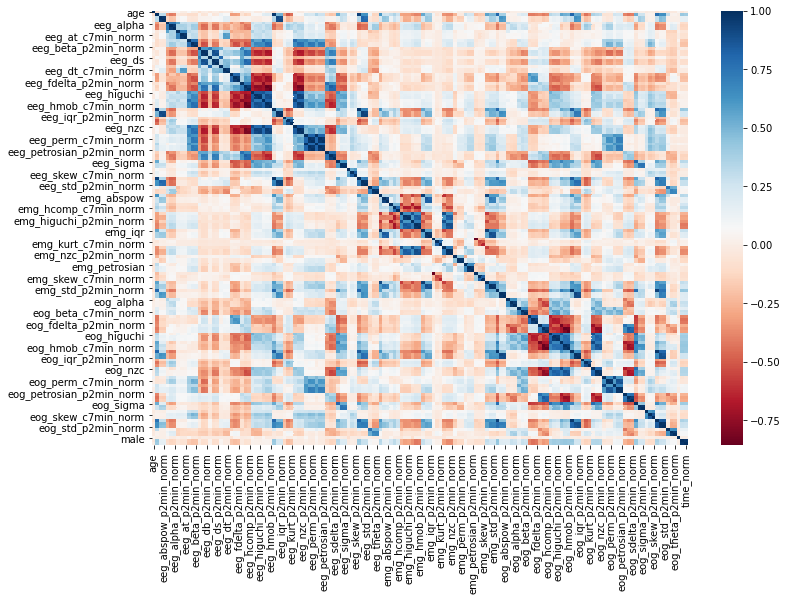

In [65]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="RdBu")

<AxesSubplot:>

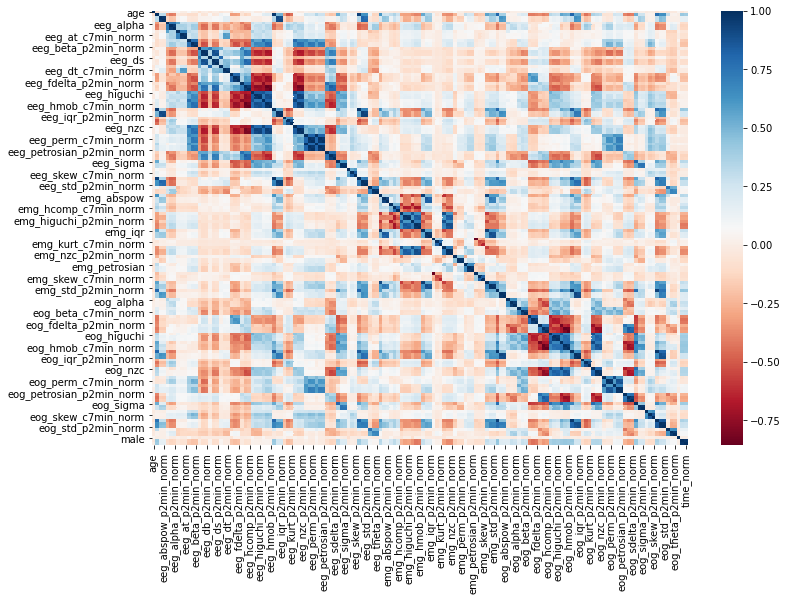

In [67]:
# with ecg
# sns.heatmap(df_ecg.corr())
plt.figure(figsize=(12,8))
sns.heatmap(df_ecg.drop(col, axis=1).corr(), cmap="RdBu")

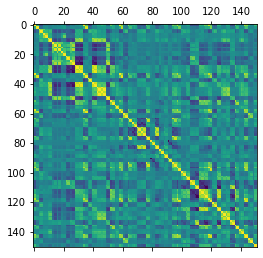

In [11]:
plt.matshow(df.corr())


<AxesSubplot:>

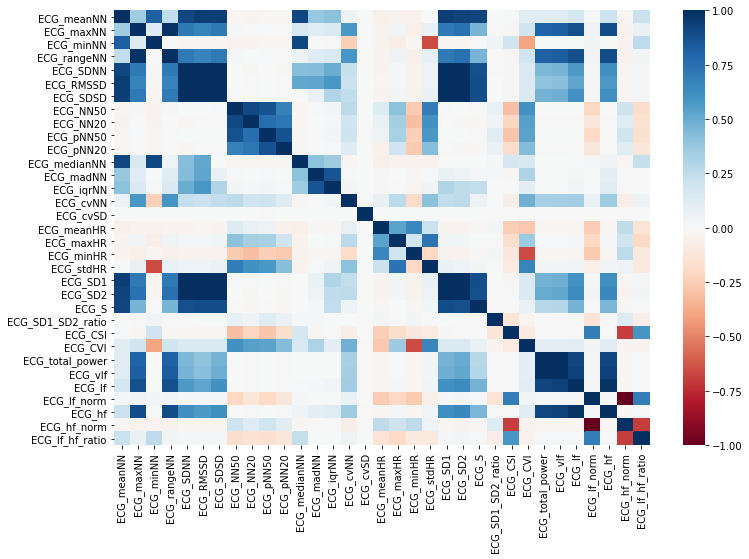

In [60]:
col = ['ECG_meanNN','ECG_maxNN','ECG_minNN','ECG_rangeNN','ECG_SDNN','ECG_RMSSD','ECG_SDSD','ECG_NN50',
       'ECG_NN20','ECG_pNN50','ECG_pNN20','ECG_medianNN','ECG_madNN','ECG_iqrNN','ECG_cvNN',
       'ECG_cvSD','ECG_meanHR','ECG_maxHR', 'ECG_minHR', 'ECG_stdHR',
       'ECG_SD1', 'ECG_SD2', 'ECG_S', 'ECG_SD1_SD2_ratio', 'ECG_CSI', 'ECG_CVI','ECG_total_power', 
       'ECG_vlf', 'ECG_lf', 'ECG_lf_norm', 'ECG_hf', 'ECG_hf_norm', 'ECG_lf_hf_ratio']

plt.figure(figsize=(12,8))
sns.heatmap(df_ecg[col].corr(), cmap="RdBu")#>0.9

### Boxplots

<ipython-input-12-9929a514eed9>:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


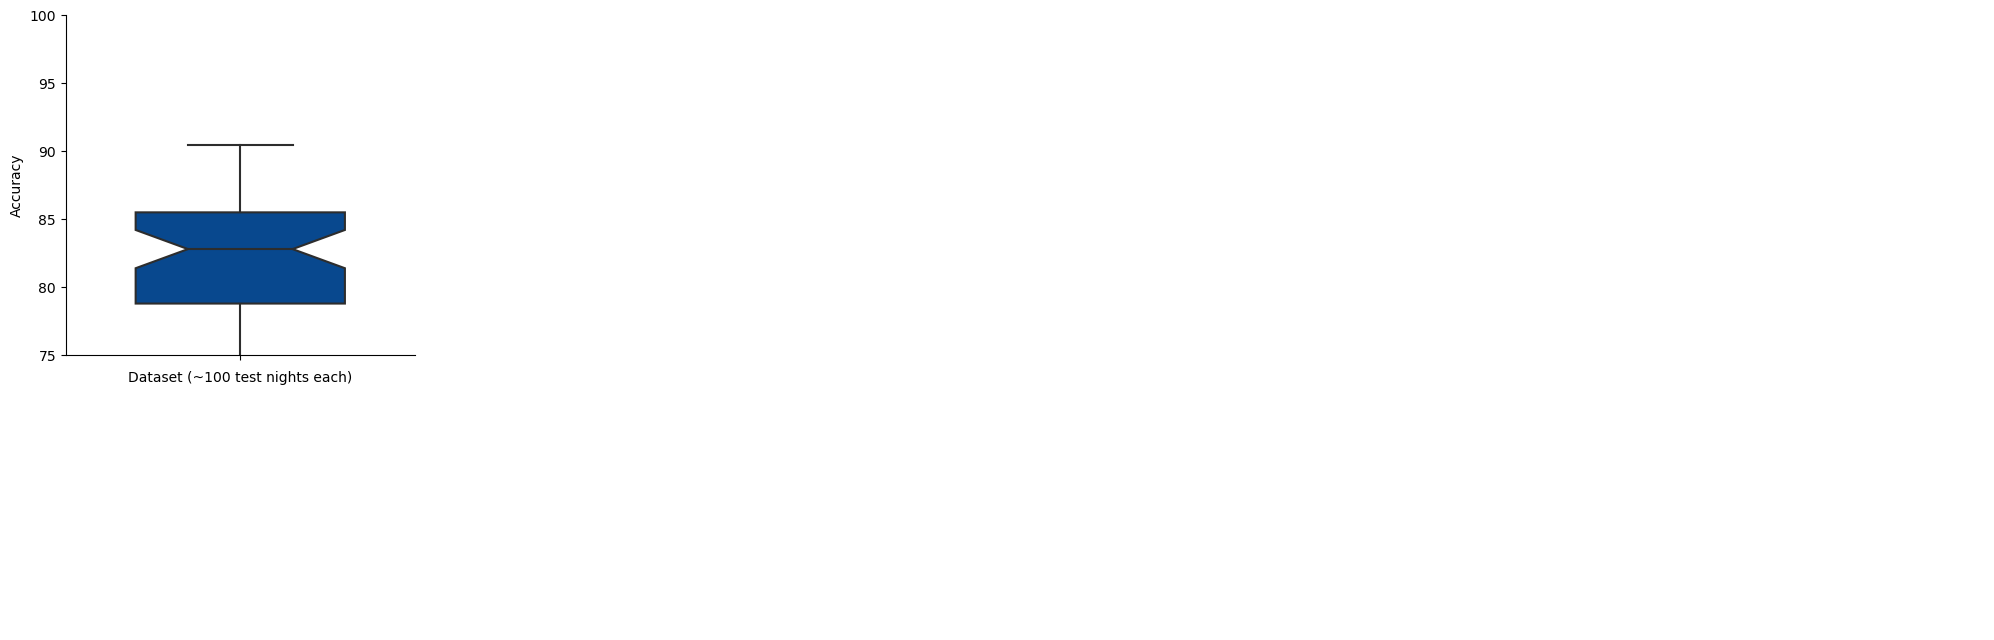

In [12]:
# Boxplot of accuracy
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5), dpi=100)
# order = df_scores['accuracy'].median().sort_values(ascending=False).index

ax1 = sns.boxplot(data=df_scores.reset_index(), y='accuracy', color=color_pred, saturation=1, 
                  fliersize=0, width=0.6, notch=True, linewidth=1.5)
                  # boxprops=dict(edgecolor="k"))

# plt.title("Performance on testing set (n=%i)" % df_scores.shape[0])
plt.xlabel("Dataset (~100 test nights each)")
plt.ylabel("Accuracy")
plt.ylim(75, 100)

ax.annotate("Accuracy (median): %.2f\nKappa (median): %.2f" % 
            (df_scores['accuracy'].median(), df_scores['kappa'].median()),
            xy=(5, 55), ha="right", fontstyle="italic", fontweight="semibold")

sns.despine()
plt.tight_layout()
plt.show()#savefig(outdir + "cv_boxplot_accuracy_datasets.png", dpi=300, bbox_inches="tight")

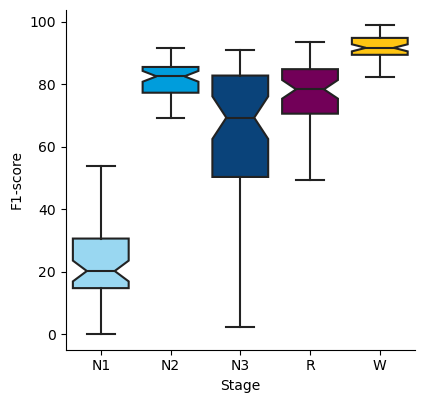

In [72]:
df_f1 = df_scores[['f1_N1', 'f1_N2', 'f1_N3', 'f1_R', 'f1_W']].copy()
df_f1.columns = df_f1.columns.str.split('_').str.get(1)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5), dpi=100)
sns.boxplot(data=df_f1, palette=cmap_stages, fliersize=0, ax=ax, saturation=1, notch=True)
plt.xlabel("Stage")
plt.ylabel("F1-score")
sns.despine()

### Confusion Matrix

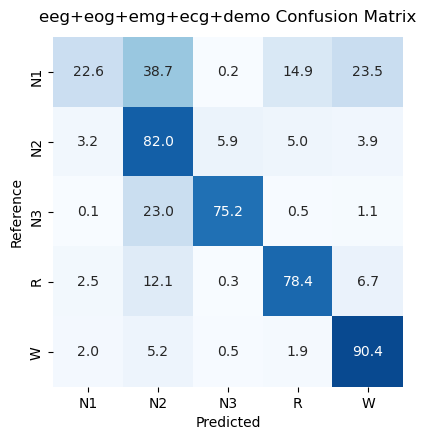

In [58]:
cm = 100 * skm.confusion_matrix(df['y_true'], df['y_pred'], labels=labels, normalize="true")
cm = pd.DataFrame(cm, index=labels, columns=labels)

# Plot
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(4.5, 4.5))
sns.heatmap(cm, annot=True, vmin=0, vmax=100, cmap="Blues", square=True, cbar=False, fmt=".1f")
plt.ylabel("Reference")
plt.xlabel("Predicted")
plt.title(f"{model} Confusion Matrix", y=1.02)#, fontweight="bold")
plt.tight_layout()
plt.show()#plt.savefig(outdir + "cv_confusion_recall.png", dpi=300, bbox_inches="tight")

### 

In [ ]:
# corr_conf = df_scores.pairwise_corr(['avg_confidence', 'accuracy']).round(3)
# display(corr_conf)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5), dpi=100)
sns.regplot(data=df_scores, x="avg_confidence", y="accuracy", truncate=True, order=1,
            scatter_kws={"s": 20, "alpha": .2, "lw": 1},
            line_kws={"color": "k", "lw": 3}, 
            color=color_pred, ax=ax)
plt.xlim(80, 100)
plt.ylim(50, 100)
plt.xlabel("Average confidence")
plt.ylabel("Accuracy")

# plt.annotate("r=%.2f" % corr_conf.loc[0, 'r'], (0.6, 0.1), xycoords="axes fraction", fontstyle="italic")
sns.despine()
plt.tight_layout()
plt.show()#plt.savefig(outdir + "cv_accuracy_confidence.png", dpi=300, bbox_inches="tight")

### Feature Importance

In [23]:
dic_features = {
    "eog_abspow": "EOG: Absolute power",
    "eeg_petrosian": "EEG: Petrosian fractal dimension",
    "eeg_abspow": "EEG: Absolute power",
    "eeg_beta": "EEG: Beta power",
    "eeg_petrosian_c7min_norm": "EEG: Petrosian fractal dimension (7.5 min)",
    "eeg_fdelta": "EEG: Fast delta power",
    "eog_fdelta_c7min_norm": "EOG: Fast delta power (7.5 min)",
    "eeg_db": "EEG: Delta/beta power ratio",
    "eeg_perm": "EEG: Permutation entropy",
    "eog_petrosian": "EOG: Petrosian fractal dimension",
    "eeg_abspow_c7min_norm": "EEG: Absolute power (7.5 min)",
    "eog_std": "EOG: Standard deviation",
    "eeg_theta_c7min_norm": "EEG: Theta power (7.5 min)",
    "eog_skew_c7min_norm": "EOG: Skewness (7.5 min)",
    "eog_higuchi_c7min_norm": "EOG: Higuchi fractal dimension (7.5 min)",
    "eog_hcomp_c7min_norm": "EOG: Hjorth complexity (7.5 min)",
    "eeg_beta_p2min_norm": "EEG: Beta power (2 min)",
    "emg_std_p2min_norm": "EMG: Standard deviation (2 min)",
    "eeg_higuchi": "EEG: Higuchi fractal dimension",
    "time_norm": "Time elapsed from beginning of recording (norm.)"
}

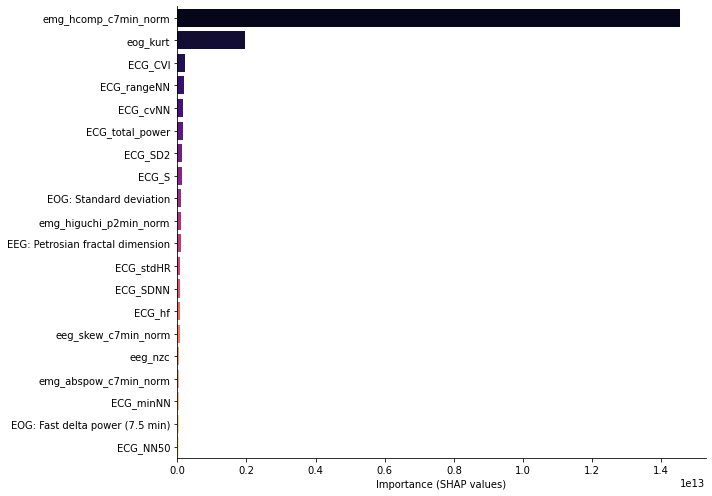

In [77]:
fimp = 'output/classifiers/clf_%s_lgb_gbdt.csv' % model
df_fimp = pd.read_csv(fimp).head(20)
df_fimp['Features'] = df_fimp['Features'].replace(dic_features)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.barplot(data=df_fimp, y="Features", x="Importance", palette="magma", saturation=1)

plt.ylabel("")
plt.xlabel("Importance (SHAP values)")
sns.despine()
plt.tight_layout()
os.makedirs(out_dir, exist_ok = True)
plt.savefig(out_dir + f"{model}_cv_fimp.png", dpi=300, bbox_inches="tight")

Interesting note: time doesn't seem to be important for sleep apnea patients as their sleep is frequently interrupted.

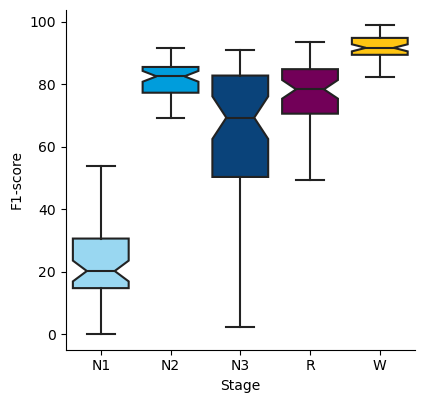